# Particle filtering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

np.set_printoptions(suppress=True, precision=4)

* Recursive Bayesian filtering by MC simulations

> They key idea is to represent the required posterior density function by a set of random samples with associated weights and to compute estimates based on these samples and weights

## Importance sampling

$$
\begin{aligned}
    \mathbb{E}[g(x) \vert {\bf y}] &\approx \frac{1}{N}\sum_{n=1}^N \frac{p(x^{(i)} \vert {\bf y})}{\pi(x^{(i)} \vert {\bf y})} g(x^{(i)} \vert {\bf y})\\
    &= \sum_{n=1}^N \tilde w^{(i)} g(x^{(i)} \vert {\bf y}),
\end{aligned}
$$

where 
$$
    \tilde w^{(i)} = \frac{p(x^{(i)} \vert {\bf y})}{N \pi(x^{(i)} \vert {\bf y})}
$$

In [3]:
# importance distribution
pi_dist = norm(0, 2)
# target distribution
p_dist = t(4, 0)

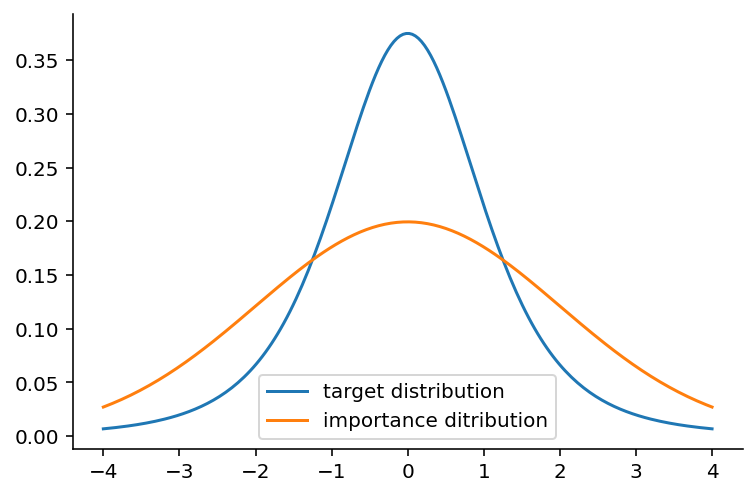

In [4]:
xrange = np.linspace(-4, 4, 200)
plt.plot(xrange, p_dist.pdf(xrange), label="target distribution")
plt.plot(xrange, pi_dist.pdf(xrange), label="importance ditribution")
plt.legend()

In [5]:
np.random.seed(314)
N = 100
# samples from the importance distribution
x_rvs = pi_dist.rvs(N)
# Samples from the target distribution
p_rvs = p_dist.rvs(N)

In [6]:
weights = p_dist.pdf(x_rvs) / (N * pi_dist.pdf(x_rvs))

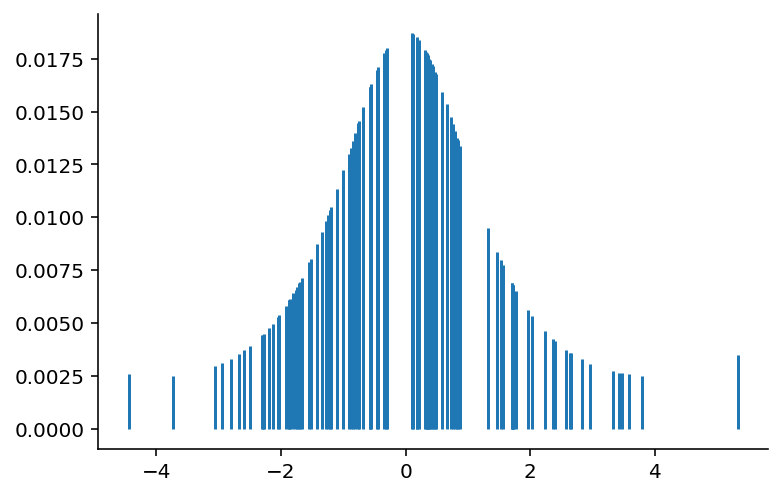

In [7]:
for xi, wi in zip(x_rvs, weights):
    plt.vlines(xi, 0, wi)

In [8]:
def g(x): return x ** 2

In [9]:
(weights * g(x_rvs)).sum()

1.6542189530195281

In [10]:
g(p_rvs).mean()

2.0109239264713437

> The disadvantage of direct importance sampling is that we should be able to evaluate $p(x^{(i)} \vert {\bf y})$ in order to use it directly.

That is, we need to compute
$$
    p(x^{(i)} \vert {\bf y}) = \frac{p(x^{(i)}) p({\bf y} \vert x^{(i)})}{\int p(x) p({\bf y} \vert x) dx},
$$

where the marginal likelihood may be difficult to compute.

## The Bootstrap filter

In [11]:
import jax
import jax.numpy as jnp
import nlds_lib as ds
from jax import random
from jax.scipy import stats
from jax.ops import index_update

1. Draw a new point ${\bf z}_t^{(n)}$ for each point in the sample set $\{{\bf z}_{t-1}^{(n)}\}_{n=1}^N$ from the model

$$
    {\bf z}_{t}^{(n)} \vert {\bf z}_{t-1}^{(n)} \sim p({\bf z}_t \vert {\bf z}_{t-1}^{(n)}) \ \forall n=1,\ldots,N
$$

2. Calculate the weights
$$
    w_{k}^{(n)} \propto p({\bf x}_t \vert {\bf z}_t^{(n)}) \forall n=1,\ldots,N,
$$
and normalize them to sum to unity

3. Do resampling

### Example

Suppose

$$
\begin{aligned}
    {\bf z}_t \vert {\bf z}_{t-1} &\sim \mathcal{N}(f_z({\bf z}_{t-1}), {\bf Q})\\
    {\bf x}_t \vert {\bf z}_{t} &\sim \mathcal{N}(f_x({\bf z}_{t}), {\bf R}) 
\end{aligned}
$$

In [12]:
def plot_samples(sample_state, sample_obs):
    fig, ax = plt.subplots()
    ax.plot(*sample_state.T, label="state space")
    ax.scatter(*sample_obs.T, s=60, c="tab:green", marker="+")
    ax.scatter(*sample_state[0], c="black", zorder=3)
    ax.legend()
    ax.set_title("Noisy observations from hidden trajectory")
    plt.axis("equal")

In [13]:
def fz(x, dt): return x + dt * jnp.array([jnp.sin(x[1]), jnp.cos(x[0])])
def fx(x): return x

In [14]:
dt = 0.4
nsteps = 100
# Initial state vector
x0 = jnp.array([1.5, 0.0])
# State noise
Qt = jnp.eye(2) * 0.001
# Observed noise
Rt = jnp.eye(2) * 0.05
alpha, beta, kappa = 1, 0, 2

key = random.PRNGKey(314)
model = ds.NLDS(lambda x: fz(x, dt), fx, Qt, Rt)
sample_state, sample_obs = model.sample(key, x0, nsteps)

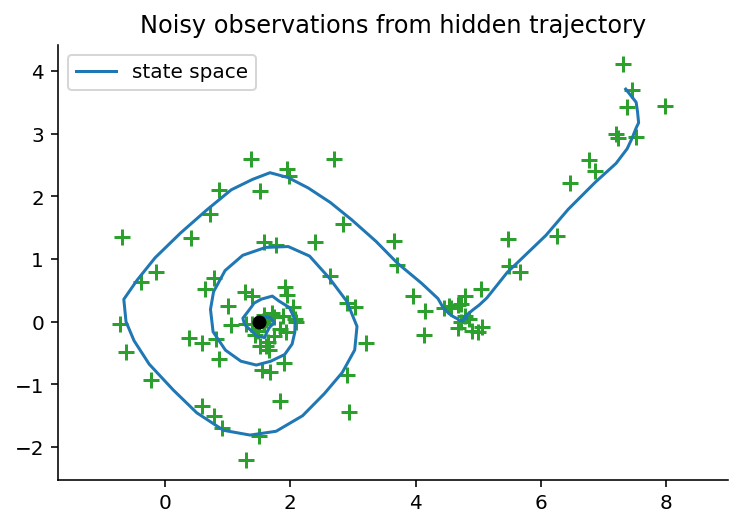

In [15]:
plot_samples(sample_state, sample_obs)

In [16]:
nsamples = 2000

#### First step

In [17]:
keys = random.split(key, nsteps)

zt_rvs = random.multivariate_normal(keys[0], x0, Qt, (nsamples,))
xt_rvs = random.multivariate_normal(keys[0], fx(zt_rvs), Rt)

In [18]:
weights_t = stats.multivariate_normal.pdf(sample_obs[0], xt_rvs, Qt)
weights_t = weights_t / weights_t.sum()
weights_t.sum()

DeviceArray(1., dtype=float32)

In [19]:
mu_t = (zt_rvs * weights_t[:, None]).sum(axis=0)
mu_t

DeviceArray([1.5   , 0.0004], dtype=float32)

#### Second step

In [20]:
fz_samples = jax.vmap(fz, in_axes=(0, None))

In [21]:
zt_rvs = random.multivariate_normal(keys[1], fz_samples(zt_rvs, dt), Qt)
xt_rvs = random.multivariate_normal(keys[1], fx(zt_rvs), Rt)

In [22]:
weights_t = stats.multivariate_normal.pdf(sample_obs[1], xt_rvs, Qt)
weights_t = weights_t / weights_t.sum()
weights_t.sum()

DeviceArray(1., dtype=float32)

In [23]:
mu_t = (zt_rvs * weights_t[:, None]).sum(axis=0)
mu_t

DeviceArray([ 1.5332, -0.0057], dtype=float32)

### All together

In [24]:
mu_hist = jnp.zeros((nsteps, 2))

for t, key_t in enumerate(keys):
    if t == 0:
        zt_rvs = random.multivariate_normal(key_t, x0, Qt, (nsamples,))
    else:
        zt_rvs = random.multivariate_normal(key_t, fz_samples(zt_rvs, dt), Qt)
        
    xt_rvs = random.multivariate_normal(key_t, fx(zt_rvs), Rt)
    
    weights_t = stats.multivariate_normal.pdf(sample_obs[t], xt_rvs, Qt)
    weights_t = weights_t / weights_t.sum()
    
    mu_t = (zt_rvs * weights_t[:, None]).sum(axis=0)
    mu_hist = index_update(mu_hist, t, mu_t)

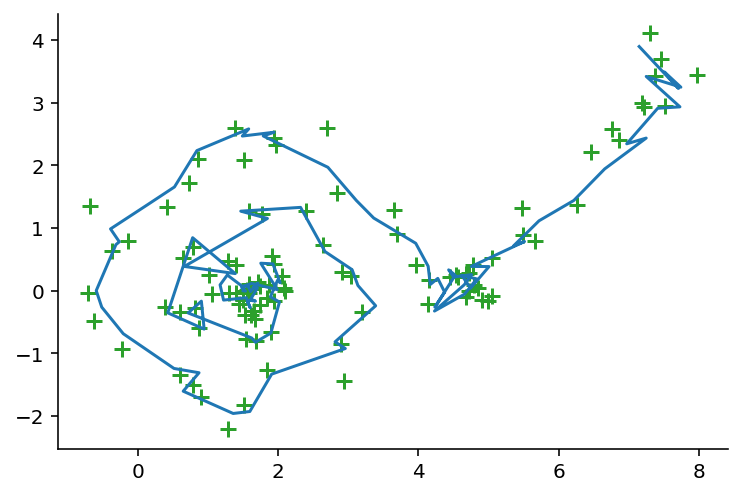

In [25]:
fig, ax = plt.subplots()
ax.plot(*mu_hist.T)
ax.scatter(*sample_obs.T, s=60, c="tab:green", marker="+")

## Rao-Blackwellized Particle Filtering (RBPF)

The RBPF considers the following system
$$
\begin{aligned}
    p({\bf z}_t \vert {\bf z}_{t-1}, {\bf u}_{t-1}) &= \mathcal{N}\big({\bf A}_t({\bf u}_{t-1}){\bf z}_{t-1}, {\bf Q}_t({\bf u}_{t-1})\big) \\
    p({\bf x}_t \vert {\bf z}_t, {\bf u}_t) &= \mathcal{N}\big({\bf H}_t({\bf u}_t) {\bf z}_t, {\bf R}_t({\bf u}_t)\big)\\
    p({\bf u}_t \vert {\bf u}_{t-1}) &= \texttt{(Any given distribution)}
\end{aligned}
$$

In [26]:
from functools import partial
from jax.scipy.special import logit

### An example: tracking a maneuvering object

In [27]:
B1 = jnp.array([0, 0, 0, 0])
B2 = jnp.array([-1.225, -0.35, 1.225, 0.35])
B3 = jnp.array([1.225, 0.35,  -1.225,  -0.35])

B_matrices = jnp.stack([B1, B2, B3], axis=0)

In [28]:
# Transition probabilities of the latent variables of the system 
transition_matrix = jnp.array([
    [0.9, 0.05, 0.05],
    [0.05, 0.9, 0.05],
    [0.05, 0.05, 0.9]
])

In [29]:
p_init = jnp.array([0, 1, 0.0])

In [30]:
Q = jnp.eye(4) * 0.8
R = jnp.eye(2) * 3
zeros = jnp.zeros(4)


TT = 1
A = jnp.array([[1, TT, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, TT],
               [0, 0, 0, 1]])

C = jnp.array([[1, 0, 0, 0], [0, 1, 0, 0]])

In [31]:
def draw_state(val, key, transition_matrix, A, B, C, Q, R):
    """
    Simulate one step of a system that evolves as
                A z_{t-1} + Bk + eps,
    where eps ~ N(0, Q).
    
    Parameters
    ----------
    val: tuple
        (state of system, value of target)
    key: PRNGKey
    A: array()
    B: array(S, M, M)
    C: array
    Q: array
    R: array
    """
    current_state, latent_val = val
    probabilities = transition_matrix[current_state, :]
    logits = logit(probabilities)
    state = jax.random.categorical(key, logits)
    
    zeros_obs, zeros_state = C.shape
    zeros_obs = jnp.zeros(zeros_obs)
    zeros_state = jnp.zeros(zeros_state)
    
    latent_val = A @ latent_val + B[state, :] + random.multivariate_normal(key, zeros_state, Q)
    obs_val = C @ latent_val + random.multivariate_normal(key, zeros_obs, R)
    
    
    return (state, latent_val), (state, latent_val, obs_val)

nparticles = 500
nsteps = 200
key = random.PRNGKey(314159)
init_key, sample_key = random.split(key, 2)
keys = random.split(sample_key, nsteps-1)

draw_state_fixed = partial(draw_state,
                           transition_matrix=transition_matrix,
                           A=A, B=B_matrices, C=C, Q=Q, R=R)

init_state = 0
init_target = random.multivariate_normal(init_key, jnp.zeros(4), jnp.identity(4))
final_state, (states, target, sample_obs) = jax.lax.scan(draw_state_fixed, (init_state, init_target), keys)

# Append initial state and starting state (target) position
states = jnp.concatenate([jnp.asarray([init_state]), states])
target = jnp.concatenate([init_target[None, :], target])

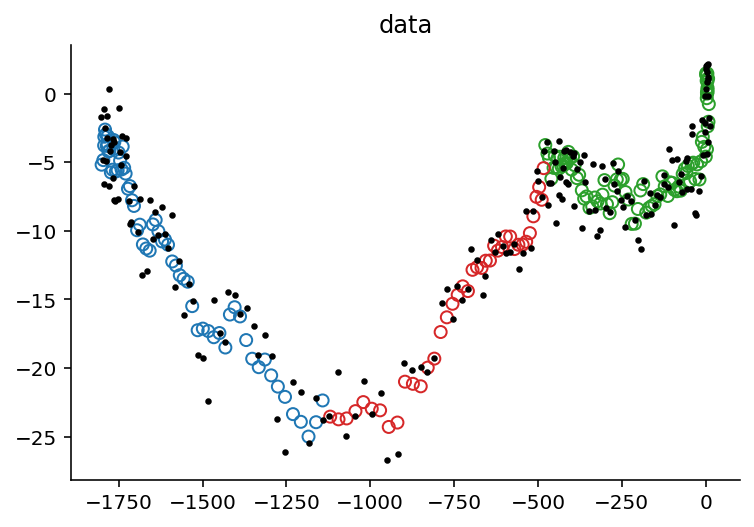

In [32]:
color_dict = {0: "tab:green", 1: "tab:red", 2: "tab:blue"}
color_states_org = [color_dict[state] for state in states]
plt.scatter(*target[:, :2].T, color="none", edgecolors=color_states_org)
plt.scatter(*sample_obs.T, s=5, c="black")
plt.title("data");

### Implementation

In [33]:
key_test = random.PRNGKey(1)

# Initial mean estimation
mu_t = 0.01 * random.normal(key, (4,))
Sigma_t = jnp.zeros((4,4))

p_step = jnp.array([0.05, 0.9, 0.05])
k = random.categorical(key, logit(p_step))

In [34]:
mu_t_cond = A @ mu_t + B_matrices[k]
Sigma_t_cond = A @ Sigma_t @ A.T + Q

xt_cond = C @ mu_t_cond
St =  C @ Sigma_t_cond @ C.T + R

In [35]:
I = jnp.eye(4)
Kt = Sigma_t_cond @ C.T @ jnp.linalg.inv(St)

# Estimation update
mu_t = mu_t_cond + Kt @ (sample_obs[0] - xt_cond)
Sigma_t  = (I - Kt @ C) @ Sigma_t_cond

In [36]:
mu_t

DeviceArray([-0.9136,  0.1034,  1.2026,  0.3488], dtype=float32)

In [37]:
from dataclasses import dataclass

@dataclass
class RBPFParams:
    A: jnp.array
    B: jnp.array
    C: jnp.array
    Q: jnp.array
    R: jnp.array
    transition_matrix: jnp.array
        
params = RBPFParams(A, B_matrices, C, Q, R, transition_matrix)

In [38]:
def kf_update(mu_t, Sigma_t, k, xt, params):
    I = jnp.eye(len(mu_t))
    mu_t_cond = params.A @ mu_t + params.B[k]
    Sigma_t_cond = params.A @ Sigma_t @ params.A.T + params.Q
    xt_cond = params.C @ mu_t_cond
    St = params.C @ Sigma_t_cond @ params.C.T + params.R
    
    Kt = Sigma_t_cond @ params.C.T @ jnp.linalg.inv(St)
    # Estimation update
    mu_t = mu_t_cond + Kt @ (xt - xt_cond)
    Sigma_t  = (I - Kt @ params.C) @ Sigma_t_cond
    # Normalisation constant
    mean_norm = params.C @ mu_t_cond
    cov_norm = params.C @ Sigma_t_cond @ params.C.T + params.R
    Ltk = jax.scipy.stats.multivariate_normal.pdf(xt, mean_norm, cov_norm)
    
    return mu_t, Sigma_t, Ltk

In [39]:
# Initial mean estimation
mu_t = 0.01 * random.normal(key, (4,))
Sigma_t = jnp.zeros((4,4))

params = RBPFParams(A, B_matrices, C, Q, R, transition_matrix)

kf_update(mu_t, Sigma_t, k, sample_obs[0], params)

(DeviceArray([-0.9136,  0.1034,  1.2026,  0.3488], dtype=float32),
 DeviceArray([[0.6316, 0.    , 0.    , 0.    ],
              [0.    , 0.6316, 0.    , 0.    ],
              [0.    , 0.    , 0.8   , 0.    ],
              [0.    , 0.    , 0.    , 0.8   ]], dtype=float32),
 DeviceArray(0.0173, dtype=float32))

In [40]:
def rbpf_step(key, weight_t, st, mu_t, Sigma_t, xt, params):
    log_p_next = logit(params.transition_matrix[st])
    k = random.categorical(key, log_p_next)
    mu_t, Sigma_t, Ltk = kf_update(mu_t, Sigma_t, k, xt, params)
    weight_t = weight_t * Ltk
    
    return mu_t, Sigma_t, weight_t

In [41]:
weights_t = jnp.ones(nparticles)
weights_t = weights_t / weights_t.sum()

In [42]:
key_test = random.PRNGKey(1)

# Initial mean estimation
mu_t = 0.01 * random.normal(key, (4,))
Sigma_t = jnp.zeros((4,4))

p_step = jnp.array([0.05, 0.9, 0.05])
st = random.categorical(key, logit(p_step))

In [43]:
key_sample = random.PRNGKey(1)
rbpf_step(key, weights_t[0], st, mu_t, Sigma_t, sample_obs[0], params)

(DeviceArray([-0.9136,  0.1034,  1.2026,  0.3488], dtype=float32),
 DeviceArray([[0.6316, 0.    , 0.    , 0.    ],
              [0.    , 0.6316, 0.    , 0.    ],
              [0.    , 0.    , 0.8   , 0.    ],
              [0.    , 0.    , 0.    , 0.8   ]], dtype=float32),
 DeviceArray(0., dtype=float32))

In [44]:
# vectorised RBPF step
rbpf_step_vec = jax.vmap(rbpf_step, in_axes=(0, 0, 0, 0, 0, None, None))

nparticles = 100
p_step = jnp.array([0.05, 0.9, 0.05])
mu_t = 0.01 * random.normal(key, (nparticles, 4))
Sigma_t = jnp.zeros((nparticles, 4,4))
keys = random.split(key_sample, nparticles)
st = random.categorical(key, logit(p_step), shape=(nparticles,))

weights_t = jnp.ones(nparticles)
weights_t = weights_t / weights_t.sum()

In [45]:
mu_particle, Sigma_particle, weights_t = rbpf_step_vec(keys, weights, st, mu_t, Sigma_t, sample_obs[0], params)
weights_t = weights_t / weights_t.sum()

In [46]:
weights_t @ mu_particle

DeviceArray([-0.8592,  0.1192,  1.1468,  0.3259], dtype=float32)

In [47]:
jnp.einsum("s,sij->ij", weights_t, Sigma_particle)

DeviceArray([[0.6316, 0.    , 0.    , 0.    ],
             [0.    , 0.6316, 0.    , 0.    ],
             [0.    , 0.    , 0.8   , 0.    ],
             [0.    , 0.    , 0.    , 0.8   ]], dtype=float32)

## All together

In [48]:
from dataclasses import dataclass

@dataclass
class RBPFParams:
    A: jnp.array
    B: jnp.array
    C: jnp.array
    Q: jnp.array
    R: jnp.array
    transition_matrix: jnp.array

In [49]:
def kf_update(mu_t, Sigma_t, k, xt, params):
    I = jnp.eye(len(mu_t))
    mu_t_cond = params.A @ mu_t + params.B[k]
    Sigma_t_cond = params.A @ Sigma_t @ params.A.T + params.Q
    xt_cond = params.C @ mu_t_cond
    St = params.C @ Sigma_t_cond @ params.C.T + params.R
    
    Kt = Sigma_t_cond @ params.C.T @ jnp.linalg.inv(St)
    
    # Estimation update
    mu_t = mu_t_cond + Kt @ (xt - xt_cond)
    Sigma_t  = (I - Kt @ params.C) @ Sigma_t_cond
    
    # Normalisation constant
    mean_norm = params.C @ mu_t_cond
    cov_norm = params.C @ Sigma_t_cond @ params.C.T + params.R
    Ltk = jax.scipy.stats.multivariate_normal.pdf(xt, mean_norm, cov_norm)
    
    return mu_t, Sigma_t, Ltk


def rbpf_step(key, weight_t, st, mu_t, Sigma_t, xt, params):
    log_p_next = logit(params.transition_matrix[st])
    k = random.categorical(key, log_p_next)
    mu_t, Sigma_t, Ltk = kf_update(mu_t, Sigma_t, k, xt, params)
    weight_t = weight_t * Ltk
    
    return mu_t, Sigma_t, weight_t, Ltk


# vectorised RBPF step
rbpf_step_vec = jax.vmap(rbpf_step, in_axes=(0, 0, 0, 0, 0, None, None))


def rbpf(current_config, xt, params, nparticles=100):
    key, mu_t, Sigma_t, weights_t, st = current_config
    
    key_sample, key_state, key_next, key_reindex = random.split(key, 4)
    keys = random.split(key_sample, nparticles)
    
    st = random.categorical(key_state, logit(params.transition_matrix[st, :]))
    mu_t, Sigma_t, weights_t, Ltk = rbpf_step_vec(keys, weights_t, st, mu_t, Sigma_t, xt, params)
    weights_t = weights_t / weights_t.sum()
    
    indices = jnp.arange(nparticles)
    pi = random.choice(key_reindex, indices, shape=(nparticles,), p=weights_t, replace=True)
#     pi = random.categorical(key_reindex, logit(weights_t), shape=(nparticles, ))
    st = st[pi]
    mu_t = mu_t[pi, ...]
    Sigma_t = Sigma_t[pi, ...]
    weights_t = jnp.ones(nparticles) / nparticles
    
    return (key_next, mu_t, Sigma_t, weights_t, st), (mu_t, Sigma_t, weights_t, st, Ltk)

In [50]:
nparticles = 10_000
key_base = random.PRNGKey(31)
key_mean_init, key_sample, key_state, key_next = random.split(key_base, 4)
p_init = jnp.array([0.0, 1.0, 0.0])
# p_init = jnp.array([1/3, 1/3, 1/3])
mu_0 = 0.01 * random.normal(key_mean_init, (nparticles, 4))
Sigma_0 = jnp.zeros((nparticles, 4,4))
s0 = random.categorical(key_state, logit(p_init), shape=(nparticles,))
weights_0 = jnp.ones(nparticles) / nparticles

In [51]:
params = RBPFParams(A, B_matrices, C, Q, R, transition_matrix)
rbpf_part = partial(rbpf, params=params, nparticles=nparticles)

_, (mu_hist, Sigma_hist, weights_hist, s_hist, _) = jax.lax.scan(rbpf_part, (key_next, mu_0, Sigma_0, weights_0, s0), sample_obs)

In [52]:
from scipy.stats import mode

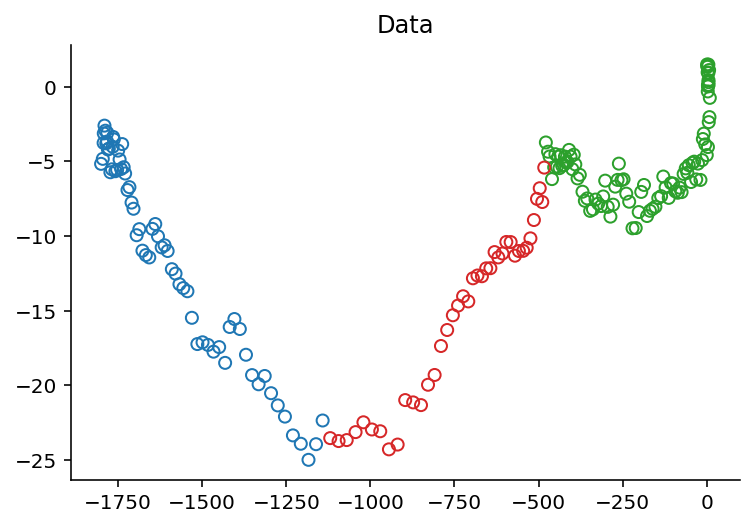

In [53]:
mu_hist_post_mean = jnp.einsum("ts,tsm->tm", weights_hist, mu_hist)
# plt.plot(*mu_hist_post_mean[:, :2].T, c="black", linestyle="--")
plt.scatter(*target[:, :2].T, color="none", edgecolors=color_states_org)
# plt.scatter(*sample_obs.T, s=5, c="black")
plt.title("Data");

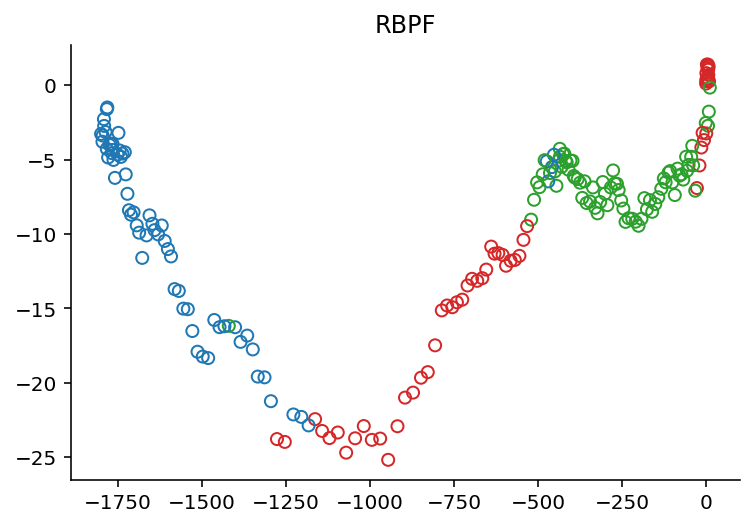

In [54]:
states = mode(np.array(s_hist), axis=1)[0].ravel()
color_states_est = [color_dict[state] for state in states]
plt.scatter(*mu_hist_post_mean[:, :2].T, edgecolors=color_states_est, c="none")
plt.title("RBPF");

## Second attempt

In [55]:
import re

In [56]:
state_string_data="""
-0.4326   -3.5524   -6.6725   -9.5294  -13.3506  -16.8812  -21.4015  -25.9034  -28.0685  -29.9390  -31.3085
-1.6656   -1.7774   -1.6908   -2.3080   -2.5438   -3.1343   -3.3785   -3.3900   -3.1036   -2.6182   -2.2052
0.1253    1.8758    3.7037    6.0745    8.8972   12.2839   16.0370   20.0302   21.8954   22.9306   23.7396
0.2877    0.6301    1.0029    1.6776    2.1656    2.4843    2.6499    2.8712    2.1464    1.7453    1.3251

-32.2463  -32.9560  -33.5381  -36.6126  -40.1482  -42.9054  -46.0508  -48.7964  -51.8154  -53.6947  -54.7941
-1.8076   -1.5696   -1.6600   -2.0849   -2.7048   -2.9474   -2.6795   -2.8482   -3.0885   -2.4314   -1.9709
23.6381   23.3285   22.5875   23.4083   24.5528   24.8014   25.5581   26.6521   27.9204   27.8532   27.2471
0.8267    0.2867   -0.1670   -0.0282    0.5125    0.6987    0.9945    1.2922    1.2791    0.6597   -0.1012

-55.5557  -56.1809  -56.5651  -56.4880  -55.8579  -55.5422  -54.6228  -53.0687  -51.3346  -48.6928  -46.1260
-1.7572   -1.3330   -0.9199   -0.6121   -0.6630   -0.1019    0.2117    0.5114    1.0441    1.2896    1.8823
25.7160   23.9386   22.3986   20.5776   17.8467   14.9342   12.0744    8.6487    4.9218    0.6329   -4.2430
-0.6981   -0.6256   -0.8341   -1.4073   -1.6649   -1.9390   -2.2967   -2.5131   -3.0845   -3.5960   -3.9727

-43.1269  -41.2142  -39.7857  -38.2190  -36.1760  -36.0160  -36.1309  -36.7379  -37.4776  -38.2454  -39.6908
1.9655    1.6327    1.5524    1.6157    1.5642    1.2412    0.9541    0.4894    0.1952   -0.0894   -0.6555
-9.2262  -13.8971  -18.2788  -22.6185  -27.0845  -29.7174  -32.1837  -33.9890  -35.1936  -36.2702  -36.9016
-4.4651   -4.4165   -4.4397   -4.1841   -3.8301   -3.7127   -2.9931   -2.6413   -2.1670   -1.8468   -1.4210

-41.7628  -43.8861  -46.3085  -48.7726  -51.9484  -55.4617  -59.3408  -63.7514  -65.5018  -66.9606  -68.3884
-0.7470   -1.1149   -1.5661   -2.1673   -2.0427   -2.5267   -3.0772   -3.1004   -2.9599   -2.3459   -1.9516
-37.0093  -37.0009  -35.6999  -34.3994  -32.7002  -30.4819  -28.1413  -25.4594  -24.6892  -24.6712  -25.5573
-0.8148   -0.2480    0.1182    0.4284    0.7251    1.1527    1.2919    1.6880    1.4249    0.6138    0.0959

-68.8187  -69.3816  -69.9778  -70.4428  -70.2215  -70.3601  -69.5683  -69.0610  -68.2108  -66.2750  -63.8380
-1.5951   -1.7209   -1.5119   -1.1341   -0.8596   -0.3926   -0.3452   -0.0860    0.3864    0.8617    1.3624
-26.3123  -28.2007  -30.1185  -32.6193  -35.5702  -38.8907  -42.3960  -46.3194  -50.7065  -55.2928  -60.3959
-0.4959   -0.7944   -1.2286   -1.5937   -1.8939   -2.0550   -2.5680   -2.8973   -3.3797   -3.8912   -4.2997

-61.0780  -60.2554  -59.8530  -60.1433  -58.4847  -56.6134  -54.4039  -52.0157  -49.5441  -48.2149  -46.4804
1.8482    1.7414    1.0917    0.4891    0.5803    1.0501    1.1684    1.2963    1.6163    1.6460    1.8282
-65.8097  -69.1427  -71.8447  -73.9427  -78.7303  -83.8581  -89.2695  -94.9489 -101.2801 -106.7607 -111.9736
-4.4494   -3.9170   -3.4564   -3.3849   -3.9322   -4.3025   -4.6045   -4.8545   -5.1420   -4.9981   -4.9578

-44.6534  -42.3014  -40.3840  -38.2109  -36.0745  -34.3184  -32.4151  -30.7373  -28.9874  -27.3314  -25.7393
1.9331    1.9492    2.1234    2.1438    1.8232    1.7587    1.7666    1.7726    1.7982    1.5643    1.3924
-116.6585 -121.7074 -126.4805 -131.2079 -136.3086 -141.5800 -146.6573 -152.4462 -158.1362 -163.5011 -169.3655
-4.8614   -4.7342   -4.7191   -5.1686   -5.1949   -5.3855   -5.7258   -5.5302   -5.5779   -5.7140   -5.4681

-24.4217  -24.4694  -24.8859  -25.4089  -26.8648  -28.0788  -29.7992  -31.7797  -34.3698  -35.7757  -37.1967
1.2260    0.9106    0.7093    0.1138    0.0164   -0.2989   -0.8377   -1.4491   -1.5608   -1.2997   -1.1623
-174.7762 -179.1984 -183.3214 -187.4849 -191.3956 -195.0726 -198.5422 -201.5115 -203.9534 -207.7071 -211.5114
-5.8318   -5.5176   -5.3335   -5.0156   -5.0784   -4.6919   -4.2711   -3.8212   -4.0000   -3.8083   -3.5955

-38.3003
-1.1904
-215.3330
-3.6541
"""


obs_string_data="""
0   -1.5887   -0.2719  -13.6800   -8.4568  -26.5057  -34.4255  -23.6214  -25.4994  -32.2038  -27.5691
0   -1.2535   -1.5129    0.2660   -0.4080   -2.3623   -3.5561   -6.4174   -0.4167   -3.5058    0.1919
0    0.7556    3.1298   13.5985   16.6387    5.9450    9.9732   19.9132   26.2812   14.0798   29.3849
0    2.8075   -1.4941   -3.1035    4.1714    6.7297    4.4933    2.7265    3.8800    1.0433   -1.6512
     
-25.7525  -28.2689  -31.5739  -27.7777  -39.3763  -42.8380  -39.2226  -52.0752  -48.9036  -50.8784  -53.9987
-2.2021    0.1373   -0.9579   -1.9177   -0.7354   -4.8828   -4.7319   -5.3885   -4.8749   -5.1421    2.8080
25.9774   18.3982   22.7163   16.1044   17.5459   29.6358   17.8064   25.1741   27.0223   28.0685   33.3576
1.0906   -0.5101   -3.1789   -0.1519   -0.8693    1.3936    0.7757    3.2813   -0.0251   -1.2229   -4.8424

-53.8228  -64.3247  -44.8208  -52.6763  -57.7839  -49.8770  -47.2581  -53.5386  -48.4216  -44.6102  -53.7490
-3.0451   -4.4008    0.5937   -2.4164    3.0466   -6.4632   -1.8769    3.1790    1.0291   -5.8042   -3.1086
26.0508   30.1656   33.5858   23.8847   14.0590   11.0661   12.1195   22.5044    3.2644    6.5736   -8.4644
-1.8017   -1.7950   -1.8535   -4.7068   -8.6405   -4.0519   -4.6454   -0.9392    0.7448   -2.9393   -3.1300

-43.1947  -48.7537  -33.4010  -41.5059  -34.2228  -28.9137  -37.7816  -31.7162  -47.9813  -52.9396  -41.6730
1.9631    0.5912    0.8162    2.3981   -1.7929    1.1949    7.5918   -1.6774    2.2872    1.3304   -2.1552
-10.7228  -19.5453  -27.3840  -22.6976  -23.3624  -26.5000  -23.1326  -38.3179  -30.3247  -35.5685  -37.1174
-3.2754   -7.9401   -4.4105   -5.9249   -0.0207   -5.8620   -8.8283   -3.2448   -0.2579   -3.6201   -1.9452

-44.7492  -49.7732  -52.7948  -46.9276  -47.7384  -53.1033  -59.7700  -59.7216  -77.0047  -56.2282  -69.6403
-4.1032   -3.1803   -4.9396   -3.8843   -3.5055   -7.6487   -2.2397   -4.6246   -1.5501   -1.1735    0.3161
-32.1634  -28.9640  -25.2859  -40.2653  -21.5253  -29.1148  -19.9017  -20.3213  -17.0431  -24.5493  -23.3029
-0.6912   -2.9757    5.9306   -0.9120    4.0456    3.2096    1.8314    2.4936    3.3406   -0.6041   -3.9403

-73.5145  -70.4846  -68.6030  -72.5942  -72.5226  -84.9038  -67.3686  -70.3848  -69.0875  -69.0430  -63.3411
-3.8970   -2.2238   -4.3904   -7.3670   -2.4450   -1.0641   -2.1035   -0.9232    1.1307   -3.3562    3.6609
-26.9555  -28.9027  -30.9948  -33.4806  -35.2379  -38.5423  -33.1715  -50.7214  -51.1663  -57.5399  -46.9749
-3.4270   -0.2889    1.0050    2.5864    1.8674   -3.3289   -2.1478   -3.0909    1.8348   -5.3039   -3.3191

-53.5218  -61.2883  -59.3521  -67.9467  -58.9144  -72.4233  -56.5092  -55.1192  -33.4024  -41.3643  -41.9032
1.9807    0.7336    5.8243   -1.3260   -6.6634    1.1342    3.8447   -0.3813    2.4854    6.3018   -2.0363
-67.6946  -65.8938  -73.8294  -82.8741  -82.8964  -89.1159  -79.7997  -99.4691 -109.8169  -98.4589 -117.6914
-3.7693   -1.1206   -1.0709   -1.7093   -8.1064   -5.0989   -7.9290   -2.0771   -4.4016   -7.2724   -2.6233

-49.3758  -32.2093  -43.5438  -41.2756  -33.1634  -32.9169  -38.6175  -30.6275  -29.5242  -37.6860  -18.8348
4.1891    3.7301    0.0669    2.8916    3.6194    5.4644   -0.5245    4.2265   -1.2716    4.0039   -0.4317
-117.6599 -116.9664 -128.0909 -128.9927 -136.8248 -145.0512 -133.5987 -148.2321 -152.5110 -154.8499 -164.5285
-7.3101   -4.4185   -8.2842   -4.6311   -4.2190   -6.8902   -4.4309   -6.2240   -8.9731   -3.6972   -4.8167

-33.8600  -27.5996  -21.6879  -31.9103  -26.1993  -23.5470  -35.1674  -34.8444  -32.6573  -45.7030  -45.2430
7.2730    5.2065    3.8079   -5.7488    4.4793    1.2252    1.5986   -0.7443    0.9174   -4.2708    0.2762
-175.2081 -184.4191 -189.6335 -192.9418 -191.0776 -194.2813 -197.8849 -205.0984 -204.0021 -203.5957 -221.3153
2.0549   -3.0949   -4.2472   -5.0324   -4.5925   -3.8516    3.9239   -3.7589   -1.4247   -6.7329   -7.9235

-41.7955
-3.8794
-213.8414
-8.1230
"""[1:]

latent_string_data = """
2     2     2     2     2     2     2     2     3     3     3     3     3     3     2     2     1     1

1     1     3     3     3     3     3     3     3     3     3     3     3     3     3     3     1     1

1     1     2     2     2     2     2     2     2     2     2     2     2     2     2     2     3     3

3     3     3     3     3     3     3     3     3     3     3     3     3     2     2     2     3     3

3     3     3     1     1     1     1     1     1     1     1     1     1     1     1     1     1     2

2     2     2     2     2     2     2     1     1     1
"""

def clean_string_data(string_data, n_rows):
    string_data = re.sub(r"[ ]+", " ", string_data).split("\n")
    final_data = [[],[], [], []]
    final_data = [[] for _ in range(n_rows)]

    l_counter = 0
    for row in string_data:
        if len(row) <= 1:
            l_counter = 0
        else:
            final_data[l_counter].append(row)
            l_counter += 1

    final_data = jnp.array([[float(element) for element in " ".join(row).split(" ")] for row in final_data]).T
    return final_data

state_data = clean_string_data(state_string_data, 4)
obs_data = clean_string_data(obs_string_data, 4)
latent_data = clean_string_data(latent_string_data, 1).ravel() - 1

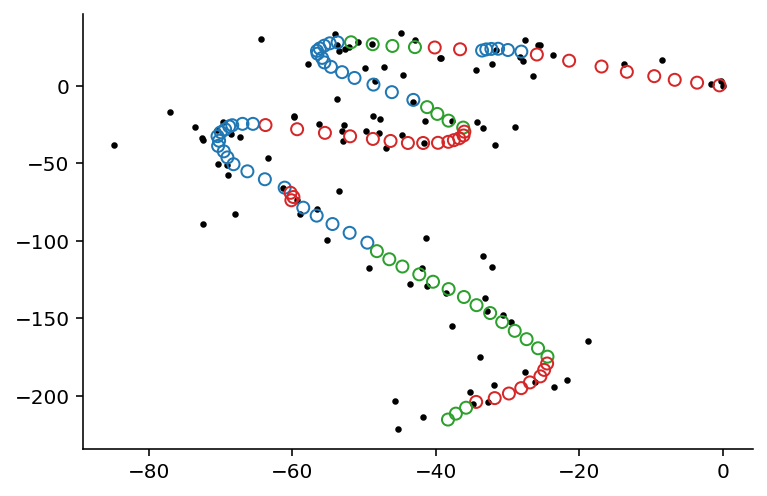

In [57]:
marker_dict = {0: "o", 1: "x", 2:"*"}
#marker_states_maneuver = [marker_dict[state] for state in states]

color_states_maneuver = [color_dict[state] for state in latent_data]

plt.scatter(*obs_data[:, [0, 2]].T, s=5, c="black")
plt.scatter(*state_data[:, [0, 2]].T, edgecolors=color_states_maneuver, c="none")

In [58]:
Q_matlab = 0.2 * jnp.eye(4)
R_matlab = 3 *  jnp.diag(jnp.asarray([2,1,2,1]))
C_matlab = jnp.eye(4)

params = RBPFParams(A, B_matrices, C_matlab, Q_matlab, R_matlab, transition_matrix)

In [59]:
key_base = random.PRNGKey(31415)
nparticles = 5000
key_mean_init, key_sample, key_state, key_next = random.split(key_base, 4)
p_init = jnp.array([0.0, 1.0, 0.0])
# p_init = jnp.array([1/3, 1/3, 1/3])
mu_0 = 0.01 * random.normal(key_mean_init, (nparticles, 4))
Sigma_0 = jnp.zeros((nparticles, 4,4))
s0 = random.categorical(key_state, logit(p_init), shape=(nparticles,))
weights_0 = jnp.ones(nparticles) / nparticles

In [60]:
rbpf_part = partial(rbpf, params=params, nparticles=nparticles)

In [61]:
_, (mu_hist, Sigma_hist, weights_hist, s_hist, Ltk) = jax.lax.scan(rbpf_part, (key_next, mu_0, Sigma_0, weights_0, s0), obs_data)
mu_hist_post_mean = jnp.einsum("ts,tsm->tm", weights_hist, mu_hist)

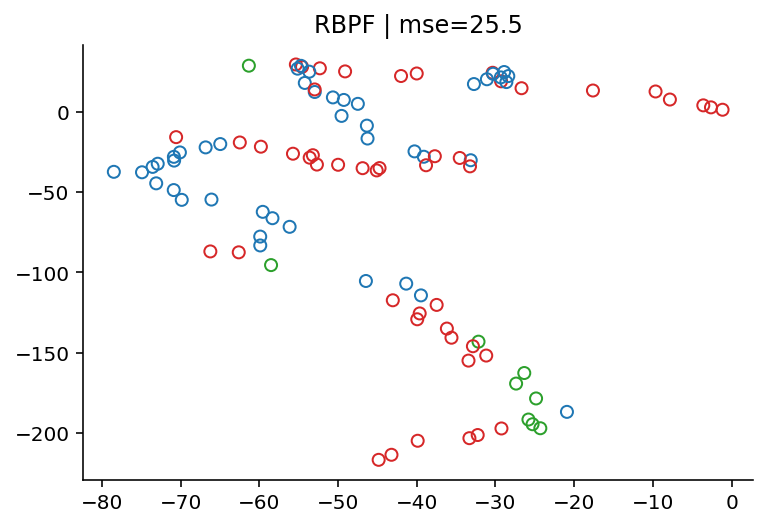

In [62]:
rbpf_mse = ((mu_hist_post_mean - state_data)[:, [0, 2]] ** 2).mean(axis=0).sum()
states = mode(np.array(s_hist), axis=1)[0].ravel()
color_states_est = [color_dict[state] for state in states]
plt.scatter(*mu_hist_post_mean[:, [0, 2]].T, edgecolors=color_states_est, c="none")
plt.title(f"RBPF | mse={rbpf_mse:0.3}");

In [67]:
transition_matrix.shape

(3, 3)

In [102]:
all_ps = jnp.arange(3)[None, None, :] * jnp.ones((100, 5000, 1)).astype(int)

In [107]:
transition_matrix[all_ps].shape

(100, 5000, 3, 3)

In [111]:
Ltk * 

(100, 5000)

In [110]:
transition_matrix[s_hist]

(100, 5000, 3)

In [108]:
(transition_matrix[..., s_hist][:, :-1, :]).shape

(3, 99, 5000)

In [71]:
p_terms = transition_matrix[..., s_hist][:, :-1, :]

log_terms = jnp.log(Ltk[None, 1:, :]) + jnp.log(p_terms)
p_terms = np.exp(log_terms - log_terms.min(axis=-1, keepdims=True))
p_terms = p_terms / p_terms.sum(axis=0, keepdims=True)
p_terms = p_terms.mean(axis=-1).T

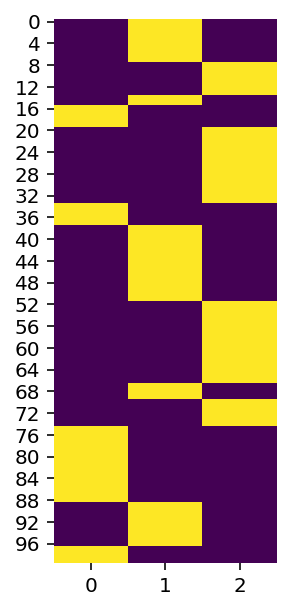

In [69]:
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

latent_hmap = ohe.fit_transform(latent_data[:, None])

fig, ax = plt.subplots(figsize=(2, 5))
sns.heatmap(latent_hmap, cmap="viridis", cbar=False);

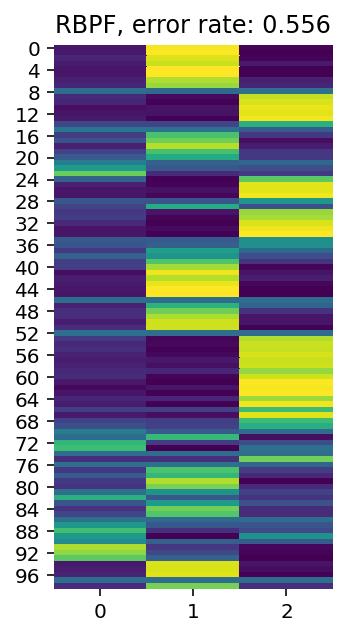

In [70]:
latent_hmap_est = ohe.fit_transform(p_terms.argmax(axis=1)[:, None])
rbpf_error_rate = (latent_data[1:] == p_terms.argmax(axis=1)).mean()

fig, ax = plt.subplots(figsize=(2.5, 5))
sns.heatmap(p_terms, cmap="viridis", cbar=False);
plt.title(f"RBPF, error rate: {rbpf_error_rate:0.3}");

## References
1. Bayesian Filtering and Smoothing - Simo Särkkä
2. RBPF implementation by K. Murphy ([code](https://github.com/probml/pmtk3/blob/master/demos/rbpfManeuverDemo.m))